In [1]:
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import numpy as np
import torch

from vade.train import TrainerVaDE

In [2]:
import torch
import numpy as np
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import Image


def global_contrast_normalization(x):
    """Apply global contrast normalization to tensor. """
    mean = torch.mean(x)  # mean over all features (pixels) per sample
    x -= mean
    x_scale = torch.mean(torch.abs(x))
    x /= x_scale
    return x

class MNIST_loader(data.Dataset):
    """This class is needed to processing batches for the dataloader."""
    def __init__(self, data, target1, target2, transform):
        self.data = data
        self.target1 = target1
        self.target2 = target2
        self.transform = transform

    def __getitem__(self, index):
        """return transformed items."""
        x = self.data[index]
        y1 = self.target1[index]
        y2 = self.target2[index]
        if self.transform:
            x = Image.fromarray(x.numpy(), mode='L')
            x = self.transform(x)
        return x, y1, y2

    def __len__(self):
        """number of samples."""
        return len(self.data)


def get_mnist(args, data_dir='./data/mnist/'):
    #get dataloders
    # min, max values for the normal data, where the anormal class is the ith index of the list.
    min_max = [(-0.82804, 20.108057),
               (-0.8826562, 13.103283),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057),
               (-0.8826562, 20.108057)]

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: global_contrast_normalization(x)),
                                    transforms.Normalize([min_max[args.anormal_class][0]],
                                                         [min_max[args.anormal_class][1] \
                                                         -min_max[args.anormal_class][0]])])
    train = datasets.MNIST(root=data_dir, train=True, download=True)
    test = datasets.MNIST(root=data_dir, train=False, download=True)

    x_train = train.data
    y_train = train.targets

    x_train = x_train[np.where(y_train!=args.anormal_class)]
    y_train = y_train[np.where(y_train!=args.anormal_class)]
    y_train = torch.Tensor([label if label<args.anormal_class else label-1 for label in y_train])
    
    N_train = int(x_train.shape[0]*0.8)
    
    x_val = x_train[N_train:]
    y1_val = y_train[N_train:]
    y2_val = np.where(y_train[N_train:]==args.anormal_class, 1, 0)
    
    data_val = MNIST_loader(x_val, y1_val, y2_val, transform)
    dataloader_val = DataLoader(data_val, batch_size=args.batch_size, 
                                  shuffle=False, num_workers=0)
    
    x_train = x_train[:N_train]
    y1_train = y_train[:N_train]
    y2_train = np.where(y_train[:N_train]==args.anormal_class, 1, 0)
                                    
    data_train = MNIST_loader(x_train, y1_train, y2_train, transform)
    dataloader_train = DataLoader(data_train, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    
    x_test = test.data
    y1_test = test.targets
    y2_test = np.where(test.targets==args.anormal_class, 1, 0)
    data_test = MNIST_loader(x_test, y1_test, y2_test, transform)
    dataloader_test = DataLoader(data_test, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    return dataloader_train, dataloader_val, dataloader_test

In [4]:
class Args:
    num_epochs=500
    num_epochs_ae=350
    patience=100
    lr=1e-4
    lr_ae = 1e-4
    lr_milestones=[100, 200, 300]
    lr_milestones_ae = [250]
    batch_size=128
    pretrain=False
    latent_dim=10
    anormal_class=1
    kl_mul = 1
    cl_mul = 1
    rec_mul = 1
    
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader_train, dataloader_val, dataloader_test = get_mnist(args)

n_classes=9
vade = TrainerVaDE(args, dataloader_train, dataloader_val, device, n_classes)
vade.train()

Training VaDE...
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 0, Loss: 2.646, Acc: 45.348
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 0, Loss: 2.134, Acc: 57.692
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 1, Loss: 2.094, Acc: 57.836
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 1, Loss: 2.030, Acc: 59.564
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 2, Loss: 2.014, Acc: 59.511
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 2, Loss: 1.986, Acc: 60.624
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 3, Loss: 1.973, Acc: 61.096
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 3, Loss: 1.955, Acc: 61.833
Weights saved.
42606/42606: [=====================

42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 35, Loss: 1.584, Acc: 87.423
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 35, Loss: 1.680, Acc: 86.094
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 36, Loss: 1.575, Acc: 88.159
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 36, Loss: 1.674, Acc: 86.413
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 37, Loss: 1.570, Acc: 88.291
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 37, Loss: 1.668, Acc: 86.852
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 38, Loss: 1.562, Acc: 89.174
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 38, Loss: 1.676, Acc: 87.541
Weights saved.
42606/42606: [==============================

10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 70, Loss: 1.625, Acc: 92.684
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 71, Loss: 1.490, Acc: 93.566
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 71, Loss: 1.630, Acc: 91.885
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 72, Loss: 1.488, Acc: 93.445
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 72, Loss: 1.631, Acc: 91.788
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 73, Loss: 1.486, Acc: 93.723
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 73, Loss: 1.628, Acc: 92.065
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 74, Loss: 1.486, Acc: 93.526
10652/10652: [===============================>] - ETA 0.0s


10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 106, Loss: 1.630, Acc: 92.308
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 107, Loss: 1.476, Acc: 94.245
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 107, Loss: 1.628, Acc: 92.363
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 108, Loss: 1.476, Acc: 94.178
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 108, Loss: 1.627, Acc: 92.889
Weights saved.
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 109, Loss: 1.477, Acc: 94.302
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 109, Loss: 1.627, Acc: 92.573
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 110, Loss: 1.477, Acc: 94.226
10652/10652: [===============================>] - ETA 0.0s
Testing

10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 142, Loss: 1.631, Acc: 92.396
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 143, Loss: 1.477, Acc: 94.147
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 143, Loss: 1.632, Acc: 92.443
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 144, Loss: 1.474, Acc: 94.462
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 144, Loss: 1.625, Acc: 92.800
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 145, Loss: 1.478, Acc: 94.101
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 145, Loss: 1.625, Acc: 92.755
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 146, Loss: 1.474, Acc: 94.271
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 146, Loss: 1.6

10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 178, Loss: 1.634, Acc: 92.629
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 179, Loss: 1.475, Acc: 94.446
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 179, Loss: 1.627, Acc: 93.200
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 180, Loss: 1.475, Acc: 94.242
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 180, Loss: 1.632, Acc: 92.327
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 181, Loss: 1.476, Acc: 94.325
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 181, Loss: 1.632, Acc: 93.047
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 182, Loss: 1.475, Acc: 94.319
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 182, Loss: 1.6

10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 214, Loss: 1.632, Acc: 92.489
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 215, Loss: 1.473, Acc: 94.526
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 215, Loss: 1.634, Acc: 92.298
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 216, Loss: 1.472, Acc: 94.513
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 216, Loss: 1.630, Acc: 92.637
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 217, Loss: 1.474, Acc: 94.382
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 217, Loss: 1.631, Acc: 92.525
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 218, Loss: 1.474, Acc: 94.407
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 218, Loss: 1.6

10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 250, Loss: 1.630, Acc: 92.990
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 251, Loss: 1.475, Acc: 94.342
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 251, Loss: 1.637, Acc: 92.415
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 252, Loss: 1.475, Acc: 94.190
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 252, Loss: 1.624, Acc: 92.897
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 253, Loss: 1.476, Acc: 94.235
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 253, Loss: 1.630, Acc: 92.504
42606/42606: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 254, Loss: 1.473, Acc: 94.385
10652/10652: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 254, Loss: 1.6

In [5]:
vade.load_weights()

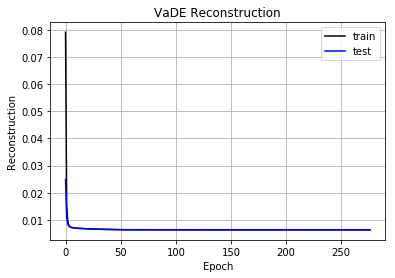

In [6]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='test')
    plt.title('VaDE {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)

plot_loss(np.array(vade.rec), np.array(vade.rec_t), 'Reconstruction')

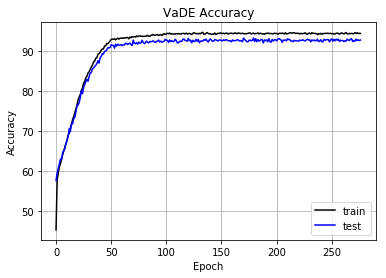

In [7]:
plot_loss(np.array(vade.acc), np.array(vade.acc_t), 'Accuracy')

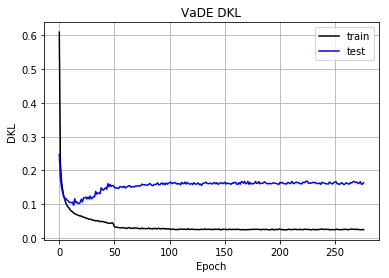

In [8]:
plot_loss(np.array(vade.dkl), np.array(vade.dkl_t), 'DKL')

In [9]:
latents = []
labels = []
mus = []
vade.VaDE.eval()

with torch.no_grad():
    for x, y, _ in dataloader_train:
        x = x.float().to(device)
        x_hat, mu, sigma, z = vade.VaDE(x)
        mus.append(mu.detach().cpu())
        latents.append(z.detach().cpu())
        labels.append(y.cpu())
labels = torch.cat(labels).numpy()
latents = torch.cat(latents).numpy()
mus = torch.cat(mus).numpy()

In [10]:
sigma

tensor([[ 1.3588e+00,  2.8294e+00,  8.1475e-01,  ...,  2.2775e-03,
         -4.4107e-01, -2.1939e+00],
        [ 1.6012e+00, -1.7499e+00,  2.6956e+00,  ..., -2.2158e+00,
          1.7266e+00, -1.3948e+00],
        [-1.0213e+00, -2.5212e+00, -6.8846e-01,  ..., -4.7868e-01,
         -1.7021e+00,  1.8249e+00],
        ...,
        [-1.0735e+00, -2.5721e+00, -6.9530e-01,  ..., -4.7942e-01,
         -1.7061e+00,  1.8500e+00],
        [-1.4505e+00,  5.6350e-01, -1.1013e+00,  ..., -2.6670e-01,
         -1.0843e-01, -7.5106e-01],
        [-1.0393e+00, -2.5186e+00, -7.0432e-01,  ..., -4.9322e-01,
         -1.7585e+00,  1.8253e+00]], device='cuda:0')

In [11]:
x_embedded = TSNE(n_components=2).fit_transform(latents[:2000])

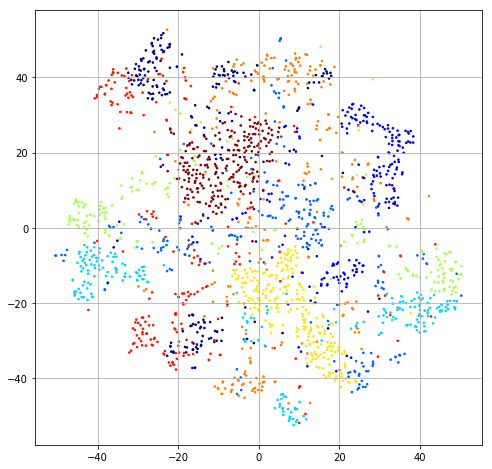

In [12]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 10)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=labels[:2000], 
            s=10, alpha=1, marker='.', cmap=cmap)
plt.grid(True)

In [13]:
x_embedded = TSNE(n_components=2).fit_transform(mus[:2000])

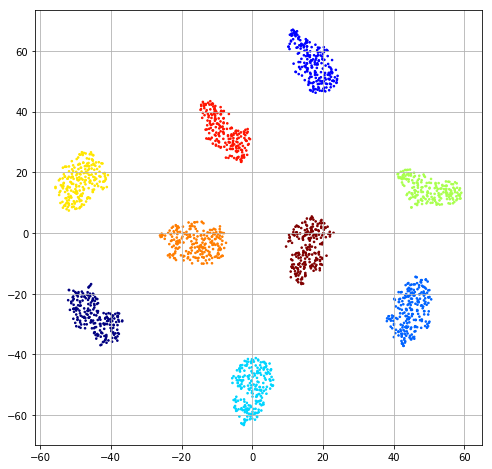

In [14]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 10)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=labels[:2000], 
            s=10, alpha=1, marker='.', cmap=cmap)
plt.grid(True)

In [17]:
import torch
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score

def eval(net, dataloader, device):
    """Testing the VaDE model"""

    scores = []
    latents = []
    labels1 = []
    labels2 = []
    net.eval()
    print('Testing...')
    with torch.no_grad():
        for x, y1, y2 in dataloader:
            x = x.float().to(device)
            x_hat, _, _, z = net(x)
            score = F.mse_loss(x_hat, x, reduction='none')
            score = torch.sum(score, dim=(1,2,3))

            scores.append(score.detach().cpu())
            latents.append(z.detach().cpu())
            labels1.append(y1.cpu())
            labels2.append(y2.cpu())
            
    labels1, labels2 = torch.cat(labels1).numpy(), torch.cat(labels2).numpy(), 
    scores, latents = torch.cat(scores).numpy(), torch.cat(latents).numpy()
    print('ROC AUC score: {:.3f}'.format(roc_auc_score(labels2, scores)))
    return labels1, labels2, scores, latents

In [18]:
labels1, labels2, scores, latent = eval(vade.VaDE, dataloader_test, device)

Testing...
ROC AUC score: 0.947


In [21]:
x_embedded = TSNE(n_components=2).fit_transform(latent[:3000])

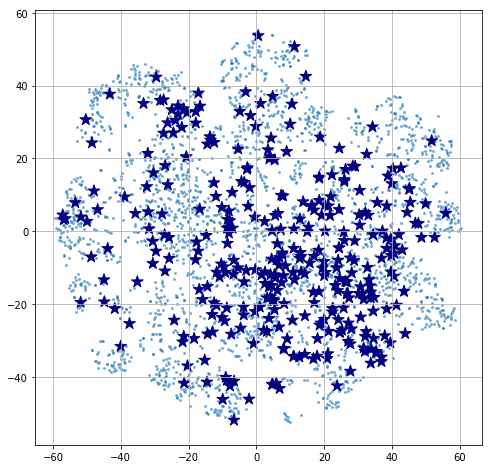

In [23]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 4)
plt.scatter(x_embedded[:, 0][labels2[:3000]==0], x_embedded[:, 1][labels2[:3000]==0],
            s=15, alpha=0.5, marker='.')
plt.scatter(x_embedded[:, 0][labels2[:3000]!=0], x_embedded[:, 1][labels2[:3000]!=0], 
            c=labels2[:3000][labels2[:3000]!=0].reshape(-1,),
            s=150, cmap=cmap, marker='*')

plt.grid(True)

In [24]:
scores_in = scores[labels2==0]
scores_out = scores[labels2==1]

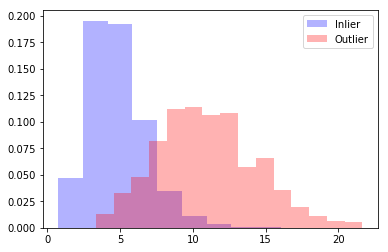

In [25]:
plt.hist(scores_in, bins=10, color='b', alpha=0.3, density=True, label='Inlier')
plt.hist(scores_out, bins=15, color='r', alpha=0.3, density=True, label='Outlier')
plt.legend()